In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from seminartools.models.utils import get_mse_by_country
from seminartools.data import read_merged
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.armax_model import ARMAXModel
from seminartools.models.uc_sv_ss_model import UCSVSSModel
from seminartools.models.random_effects_model import RandomEffectsModel
from seminartools.models.distance_model import DistanceModel
from seminartools.models.mucsvss_model import MUCSVSSModel
from seminartools.models.pca_var_model import PCAVARModel



muc_model = MUCSVSSModel(num_particles=100008, stochastic_seasonality=True)
muc_model.load_from_disk("../../models/mucsvss_model_100008_deterministic_all.pkl")
muc_model

I0000 00:00:1713777895.946163 3571810 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [4]:
df = read_merged().reset_index()


In [5]:
# expanding window crossval
from seminartools.time_series_split import ExpandingWindowSplit

tss = ExpandingWindowSplit(start_date = "2000-01-01")
tss

# Try multistep ahead UCSVSS model

In [5]:
UCSV = UCSVSSModel(num_particles = 10000, stochastic_seasonality=False)
UCSV.full_fit(df)
UCSV

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 1112.47it/s]


In [6]:
from seminartools.models.utils import h_period_ahead_forecast

forecast = h_period_ahead_forecast(UCSV, df, "2010-01-01", h=1)
forecast

,inflation,country,date
0,0.000124,Japan,2010-01-01
1,0.004801,Canada,2010-01-01
2,0.006586,United States,2010-01-01
3,0.006888,Australia,2010-01-01
4,0.006481,New Zealand,2010-01-01
...,...,...,...
1055,0.007293,Norway,2023-01-01
1056,0.029420,Belgium,2023-01-01
1057,0.006645,Korea,2023-01-01
1058,0.012935,South Africa,2023-01-01


In [7]:
from seminartools.models.utils import make_oos_predictions

forecast = make_oos_predictions(lambda: UCSVSSModel(num_particles = 1000, stochastic_seasonality=False), df,tss,h=4)
forecast

Fitting model on the full dataset... (model=<seminartools.models.uc_sv_ss_model.UCSVSSModel object at 0x7f43bc509c10>)


100%|██████████| 20/20 [00:00<00:00, 4049.34it/s]

Fitted!


,inflation,country,date
0,0.001653,Japan,2000-01-01
1,0.002556,Canada,2000-01-01
2,0.004002,United States,2000-01-01
3,0.000940,Australia,2000-01-01
4,-0.000287,New Zealand,2000-01-01
...,...,...,...
1821,0.005956,Norway,2023-01-01
1822,0.030965,Belgium,2023-01-01
1823,0.006170,Korea,2023-01-01
1824,0.012872,South Africa,2023-01-01


/home/maurits/private/seminar/seminartools/models/armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast += exog_coefs[j] * exogData[i-1]
/home/maurits/private/seminar/seminartools/models/armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast += exog_coefs[j] * exogData[i-1]
/home/maurits/private/seminar/seminartools/models/armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fore

,date,country,inflation
0,2000-01-01,Japan,-0.007854
1,2000-01-01,Canada,-0.008615
2,2000-01-01,United States,0.004917
3,2000-01-01,Australia,0.003646
4,2000-01-01,New Zealand,0.000415
...,...,...,...
1516,2023-01-01,Norway,0.004521
1517,2023-01-01,Belgium,0.012320
1518,2023-01-01,Korea,0.010256
1519,2023-01-01,South Africa,0.009348


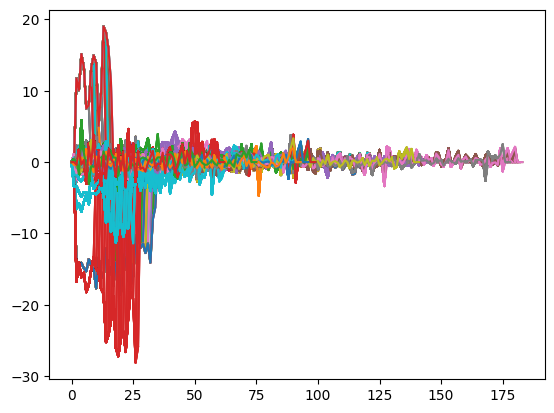

In [8]:
from seminartools.models.utils import make_oos_predictions

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]
forecast = make_oos_predictions(lambda: ARMAXModel(max_p=2, max_q=0, exogenous_columns=exog_columns), df,tss,h=4)
forecast

In [9]:
f = forecast['inflation']
f


0      -0.007854
1      -0.008615
2       0.004917
3       0.003646
4       0.000415
          ...   
1516    0.004521
1517    0.012320
1518    0.010256
1519    0.009348
1520    0.031694
Name: inflation, Length: 1521, dtype: float64

# 1. Get stats for four steps ahead forecast

In [8]:
from seminartools.models.utils import get_stats
from seminartools.models.cov_bhm_model import CovBHMModel

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]

stats = get_stats(
    [
        # ("4qa", lambda: FourQuarterAverageModel()),
        ("pca_var", lambda: PCAVARModel(standardize_pre_post=True)),
        # ("ar", lambda: ARMAXModel(max_p=2, max_q=0)),
        # (
        #     "arx",
        #     lambda: ARMAXModel(max_p=2, max_q=0, exogenous_columns=exog_columns),
        # ),
        # ("arma", lambda: ARMAXModel(max_p=2, max_q=2)),
        # (
        #     "armax",
        #     lambda: ARMAXModel(max_p=2, max_q=2, exogenous_columns=exog_columns),
        # ),
        (
            "uc_sv",
            lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=False),
        ),
        # (
        #     "uc_sv_ss",
        #     lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=True),
        # ),
        # ("random_effects", lambda: RandomEffectsModel()),
        # (
        #     "random_effects_x",
        #     lambda: RandomEffectsModel(exogenous_columns=exog_columns),
        # ),
        # ("distance", lambda: DistanceModel()),
        # ("distance_x", lambda: DistanceModel(exogenous_columns=exog_columns)),
        # ("mucsvss", lambda: muc_model),
         ("cov_bhm", lambda: CovBHMModel()),
         ("cov_bhm_x", lambda: CovBHMModel(exogenous_columns=exog_columns)),
    ],
    df,
    tss,
    h=4,
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
    # num_cores_parallel_splits=5
)
stats

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


Fitting model on the full dataset... (model=<seminartools.models.uc_sv_ss_model.UCSVSSModel object at 0x7f0b954e3cd0>)


100%|██████████| 20/20 [00:00<00:00, 117.62it/s]


In [17]:
# format r2 column to 2 
format_stats = stats.copy()
format_stats['p-value'] =format_stats['p-value'].astype(float)
round_cols = ["r2", "mz_intercept", "mz_slope", "mz_r2", "mz_wald_test_statistic", "p-value"]
for col in round_cols:
    format_stats[col] = format_stats[col].apply(lambda x: round(x, 3))

format_stats['mz_wald_test_statistic'] = format_stats['mz_wald_test_statistic'].astype(str) + '(' + format_stats['p-value'].astype(str) + ')'
format_stats.drop(columns = ['p-value'], inplace = True)

# get relative to UCSV
format_stats.loc[:,["mse","mae"]] = format_stats.loc[:,["mse","mae"]].div(format_stats.loc["uc_sv",["mse","mae"]])
format_stats

KeyError: 'uc_sv'

In [ ]:
# generate latex code for the stats table
print(
    # replace _ by \_ in columns and index
    format_stats.pipe(lambda df: df.rename(columns=lambda x: x.replace("_", "\\_")))
    .pipe(lambda df: df.rename(index=lambda x: x.replace("_", "\\_")))
    .to_latex(
        index=True,
        caption="MSPE, MAE, $R^2$, and Mincer-Zarnowitz statistics, out-of-sample, 2000-2023",
        label="tab:model_eval",
        float_format="%.4f",
    )
)

\begin{table}
\caption{MSPE, MAE, $R^2$, and Mincer-Zarnowitz statistics, out-of-sample, 2000-2023}
\label{tab:model_eval}
\begin{tabular}{lllrrrrl}
\toprule
 & mse & mae & r2 & mz\_intercept & mz\_slope & mz\_r2 & mz\_wald\_test\_statistic \\
\midrule
ar & 0.9577 & 1.0004 & 0.2450 & -0.0010 & 1.0760 & 0.2520 & 6.781(0.001) \\
4qa & 0.9593 & 0.9871 & 0.2080 & 0.0020 & 0.7350 & 0.2440 & 40.502(0.0) \\
distance & 0.9609 & 0.9968 & 0.2050 & -0.0000 & 0.9790 & 0.2080 & 2.932(0.054) \\
random\_effects & 0.9716 & 1.0057 & 0.1960 & -0.0010 & 1.0570 & 0.2010 & 5.031(0.007) \\
arma & 0.9751 & 0.9947 & 0.2320 & 0.0010 & 0.8250 & 0.2440 & 11.38(0.0) \\
random\_effects\_x & 0.9946 & 1.0112 & 0.1770 & 0.0020 & 0.8880 & 0.1950 & 17.787(0.0) \\
uc\_sv & 1.0000 & 1.0000 & 0.1710 & 0.0020 & 0.8270 & 0.1840 & 14.239(0.0) \\
distance\_x & 1.0922 & 1.0698 & 0.0960 & 0.0030 & 0.6270 & 0.1680 & 68.867(0.0) \\
uc\_sv\_ss & 1.3881 & 1.2307 & -0.1510 & 0.0040 & 0.3380 & 0.0500 & 185.6(0.0) \\
mucsvss & 4.4911 